# PROYECTO TELECOM CHURN

#### Objetivo del Proyecto --> Predecir si un cliente se dará de baja (Churn = True) usando sus datos de uso y características contractuales.

In [1]:
!pip install pandasql

In [328]:
from scipy import stats
from sklearn import linear_model
from scipy.stats import chi2_contingency , ttest_ind

import pandas as pd
import pandasql as ps
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# PASO 1 – INSPECCIÓN INICIAL DE LOS DATOS

In [4]:
df = pd.read_csv("churn-bigml-80.csv")
df

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,SC,79,415,No,No,0,134.7,98,22.90,189.7,68,16.12,221.4,128,9.96,11.8,5,3.19,2,False
2662,AZ,192,415,No,Yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
2663,WV,68,415,No,No,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
2664,RI,28,510,No,No,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False


In [7]:
df.shape

(2666, 20)

- 2.666 filas → Cada fila representa un cliente.

- 20 columnas → Cada columna es una característica del cliente o una variable asociada al servicio.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

Observaciones:

- No hay valores nulos en ninguna columna (2666 non-null) ✅

- Los tipos de datos están correctamente asignados, menos Area code que tenemos que modificar a category.

    - Variables numéricas están como int64 o float64 (correcto).

    - Variables categóricas (object) como 'State', 'International plan', 'Voice mail plan' están como object, que es lo normal en pandas.

    - La variable objetivo Churn ya está en formato bool (booleano), lo cual es ideal para clasificación binaria.

In [352]:
# modificanco Area Code de int para category
df["Area code"] = df["Area code"].astype("category")

In [11]:
df.describe()

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
count,2666.000000,2666.000000,2666.000000,2666.00000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,100.620405,437.438860,8.021755,179.48162,100.310203,30.512404,200.386159,100.023631,17.033072,201.168942,100.106152,9.052689,10.237022,4.467367,2.764490,1.562641
std,39.563974,42.521018,13.612277,54.21035,19.988162,9.215733,50.951515,20.161445,4.330864,50.780323,19.418459,2.285120,2.788349,2.456195,0.752812,1.311236
min,1.000000,408.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,43.700000,33.000000,1.970000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,408.000000,0.000000,143.40000,87.000000,24.380000,165.300000,87.000000,14.050000,166.925000,87.000000,7.512500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,415.000000,0.000000,179.95000,101.000000,30.590000,200.900000,100.000000,17.080000,201.150000,100.000000,9.050000,10.200000,4.000000,2.750000,1.000000
75%,127.000000,510.000000,19.000000,215.90000,114.000000,36.700000,235.100000,114.000000,19.980000,236.475000,113.000000,10.640000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,50.000000,350.80000,160.000000,59.640000,363.700000,170.000000,30.910000,395.000000,166.000000,17.770000,20.000000,20.000000,5.400000,9.000000


### Analizamos algunas estadísticas numéricas:

| Columna                 | Media  | Desviación Estándar | Observaciones                                                                 |
|-------------------------|--------|----------------------|--------------------------------------------------------------------------------|
| Account length          | 100.6  | 39.6                 | Clientes con cuentas recientes y otras más antiguas.                          |
| Area code               | 437.4  | 42.5                 | Solo hay 3 valores: 408, 415, 510. Puede usarse como categórica.              |
| Number vmail messages   | 8.02   | 13.6                 | 50% de los clientes tienen 0 mensajes de voz. Asimetría alta.                 |
| Total day minutes       | 179.5  | 54.2                 | Uso promedio diario. Hay clientes con 0 minutos.                              |
| Total intl minutes      | 10.2   | 2.79                 | Uso bajo de llamadas internacionales.                                         |
| Customer service calls  | 1.56   | 1.31                 | La mayoría hizo 0–2 llamadas. Algunos hasta 9. Puede estar relacionado con churn. |




Algunas variables como Total day charge, Total eve charge, Total night charge, Total intl charge son proporcionales a los minutos. Podrían eliminarse más adelante para evitar duplicidad.

### Conclusiones del Paso 1

1. El dataset está limpio: no hay valores faltantes y los tipos son adecuados.

2. Algunas variables tienen distribuciones muy asimétricas (como Number vmail messages) → se deben explorar en profundidad.

3. Existen variables duplicadas (costo y minutos) → podríamos eliminar algunas más adelante.

4. Variables como Customer service calls, International plan y Voice mail plan parecen relevantes para el modelo.

# Tipo y descripción de las Variables

| Variable                  | Tipo de Dato | Tipo Estadístico        | Descripción                                         |
|---------------------------|---------------|---------------------------|-----------------------------------------------------|
| State                     | Categórica    | Cualitativa Nominal       | Estado del cliente (abreviatura de EE.UU.)         |
| Account length            | Numérica      | Cuantitativa Discreta     | Cuántos días el cliente ha estado con la empresa   |
| Area code                 | Categórica    | Cualitativa Nominal       | Código de área telefónica                          |
| International plan        | Categórica    | Cualitativa Binaria       | Si tiene plan internacional (Yes/No)               |
| Voice mail plan           | Categórica    | Cualitativa Binaria       | Si tiene buzón de voz (Yes/No)                     |
| Number vmail messages     | Numérica      | Cuantitativa Discreta     | Número de mensajes en buzón de voz                 |
| Total day minutes         | Numérica      | Cuantitativa Continua     | Minutos usados durante el día                      |
| Total day calls           | Numérica      | Cuantitativa Discreta     | Llamadas realizadas durante el día                 |
| Total day charge          | Numérica      | Cuantitativa Continua     | Cargo por llamadas diurnas                         |
| Total eve minutes         | Numérica      | Cuantitativa Continua     | Minutos usados en la tarde                         |
| Total eve calls           | Numérica      | Cuantitativa Discreta     | Llamadas realizadas en la tarde                    |
| Total eve charge          | Numérica      | Cuantitativa Continua     | Cargo por llamadas de tarde                        |
| Total night minutes       | Numérica      | Cuantitativa Continua     | Minutos usados de noche                            |
| Total night calls         | Numérica      | Cuantitativa Discreta     | Llamadas realizadas en la noche                    |
| Total night charge        | Numérica      | Cuantitativa Continua     | Cargo por llamadas nocturnas                       |
| Total intl minutes        | Numérica      | Cuantitativa Continua     | Minutos de llamadas internacionales                |
| Total intl calls          | Numérica      | Cuantitativa Discreta     | Cantidad de llamadas internacionales               |
| Total intl charge         | Numérica      | Cuantitativa Continua     | Cargo por llamadas internacionales                 |
| Customer service calls    | Numérica      | Cuantitativa Discreta     | Número de veces que llamó al servicio al cliente   |
| Churn                     | Categórica    | Cualitativa Binaria       | Variable objetivo: ¿el cliente se dio de baja?     |


# Paso 2: División de variables categóricas y cuantitativas

In [358]:
df_categoricas = df[["State", "Area code", "International plan", "Voice mail plan", "Churn"]]

df_cuantitativas = df[['Account length', 'Number vmail messages', 'Total day minutes',
             'Total day calls', 'Total day charge', 'Total eve minutes',
             'Total eve calls', 'Total eve charge', 'Total night minutes',
             'Total night calls', 'Total night charge', 'Total intl minutes',
             'Total intl calls', 'Total intl charge', 'Customer service calls',
             'Churn']]

In [360]:
print("df_categoricas.shape: ", df_categoricas.shape)
print("df_cuantitativas.shape: ", df_cuantitativas.shape)

df_categoricas.shape:  (2666, 5)
df_cuantitativas.shape:  (2666, 16)


# 3. Estudio de relaciones entre varibles

## 3.1 Churn y variables categóricas: 
### Vamos a analizar cómo se relaciona la variable objetivo Churn (si el cliente canceló o no) con las variables categóricas.

### a) Churn vs International plan

In [17]:
pd.crosstab(df["International plan"],df["Churn"],margins=True)

Churn,False,True,All
International plan,,,
No,2126,270,2396
Yes,152,118,270
All,2278,388,2666


In [382]:
c_i = pd.crosstab(df["International plan"],df["Churn"],normalize="index")*100
c_i

Churn,False,True
International plan,,
No,88.731219,11.268781
Yes,56.296296,43.703704


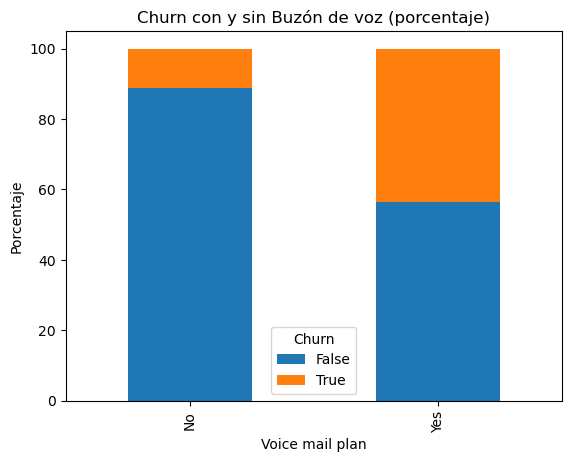

In [384]:
c_i.plot(kind='bar', stacked=True)
plt.title("Churn con y sin Buzón de voz (porcentaje)")
plt.ylabel("Porcentaje")
plt.xlabel("Voice mail plan")
plt.legend(title="Churn")
plt.show()

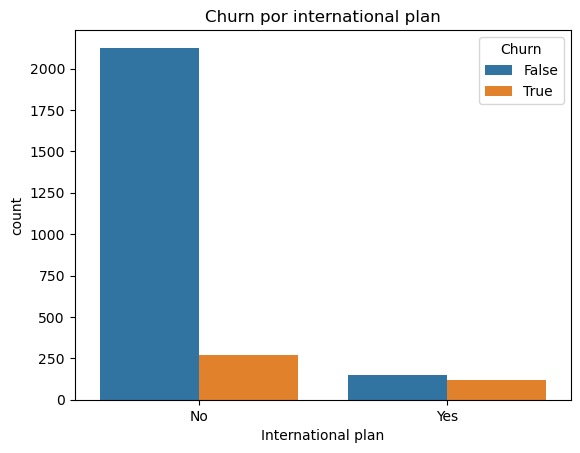

In [21]:
sns.countplot(data=df_categoricas, x = "International plan", hue = "Churn")
plt.title("Churn por international plan")
plt.show()

- Aqui podemos notar que los clientes que no tienen plan internacional renovan cerca de ~89%, ya los cliente que tienen el plan internacional renovan apenas un ~56%.
- Hay que tener en cuenta que de los 2666 clientes casi 2400 no tienen plan internacional

#### Conclusión: Los clientes con plan internacional tienen una probabilidad 4 veces mayor de cancelar (churn = 43.7%) comparado con los que no lo tienen (11.3%).

📌 Variable muy relevante. Puede ser un buen predictor para modelos.

### b) Churn vs Voice mail plan  (Si tiene buzón de voz (Yes/No))

In [388]:
pd.crosstab(df["Voice mail plan"],df["Churn"],margins = True)

Churn,False,True,All
Voice mail plan,,,
No,1610,323,1933
Yes,668,65,733
All,2278,388,2666


In [374]:
tabla = pd.crosstab(df["Voice mail plan"], df["Churn"], normalize = "index") * 100
tabla

Churn,False,True
Voice mail plan,,
No,83.290222,16.709778
Yes,91.132333,8.867667


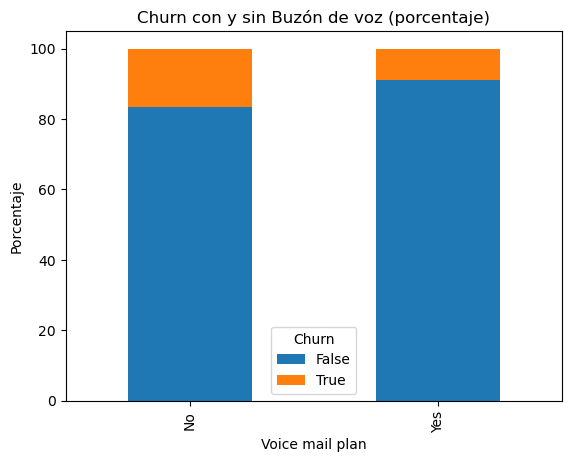

In [380]:
tabla.plot(kind='bar', stacked=True)
plt.title("Churn con y sin Buzón de voz (porcentaje)")
plt.ylabel("Porcentaje")
plt.xlabel("Voice mail plan")
plt.legend(title="Churn")
plt.show()

- 72.5% dos clientes no tienen buzon de voz, contra un 27,5% que tienen
- 1933 clientes no tienen buzon de voz y un 83,3% renovan
- 733 clientes tienen buzon y un 91,1% hacen la renovacion

### Conclusión: Tener buzón de voz se asocia a menor tasa de cancelación (sólo 8.9% de churn frente a 16.7% sin buzón).
📌 Variable útil para análisis y posible protección contra churn.

### c) Churn vs Area code

In [362]:
pd.crosstab(df["Area code"],df["Churn"],margins=True)

Churn,False,True,All
Area code,,,
408,575,94,669
415,1123,195,1318
510,580,99,679
All,2278,388,2666


In [364]:
pd.crosstab(df["Area code"],df["Churn"], normalize="index") *100

Churn,False,True
Area code,,
408,85.949178,14.050822
415,85.204856,14.795144
510,85.419735,14.580265


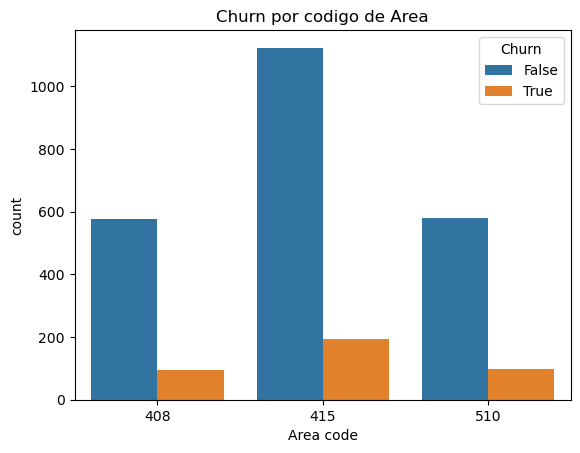

In [366]:
sns.countplot(data=df_categoricas, x="Area code", hue="Churn")
plt.title("Churn por codigo de Area")
plt.show()

### Total de clientes por codigo:

- Se puede notar que en todas las areas tienen una retencion de ~85% 
- en el codigo de area 415 es donde hay la mayor parte de clientes

### Conclusión: No hay gran diferencia entre códigos de área, las tasas de churn son similares (~14%).
📌 Esta variable parece menos informativa para predecir churn. Puedes considerarla para eliminarla más adelante.

### d) Churn vs State

In [35]:
churn_state = pd.crosstab(df["State"], df["Churn"], normalize="index") * 100

churn_state = churn_state.sort_values( by=True, ascending=False).round(2)

churn_state



Churn,False,True
State,,
TX,70.91,29.09
NJ,72.00,28.00
AR,76.60,23.40
MD,76.67,23.33
MS,77.08,22.92
SC,77.55,22.45
ME,77.55,22.45
MI,77.59,22.41
PA,77.78,22.22


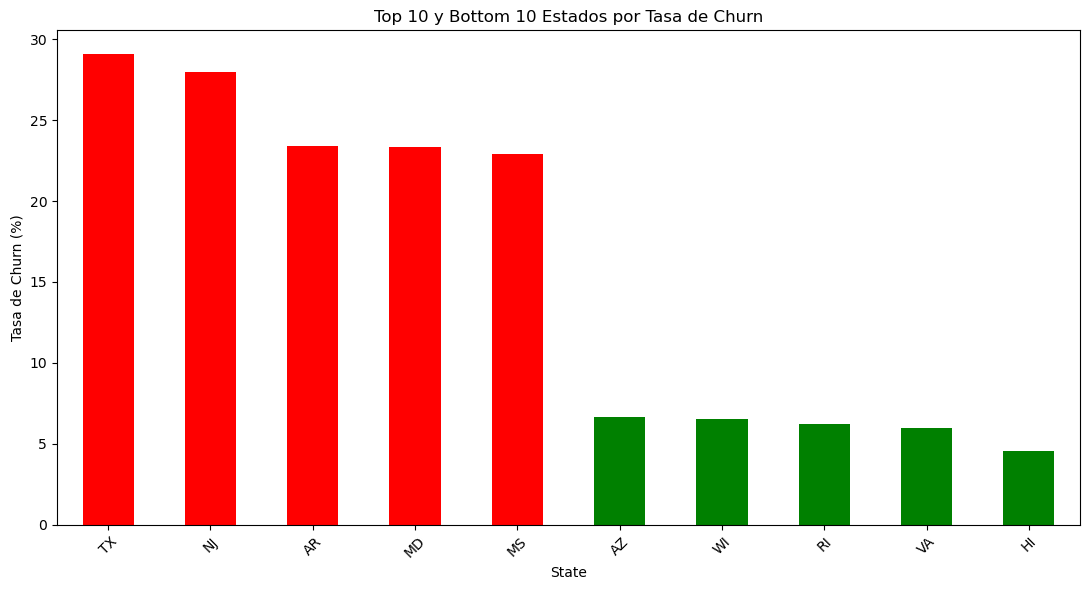

In [368]:
# Top 10 estados com maior taxa de churn
top_10 = df_categoricas.groupby("State")["Churn"].mean().sort_values(ascending=False).head(5)

# Top 10 estados com menor taxa de churn
bottom_10 = df_categoricas.groupby("State")["Churn"].mean().sort_values(ascending=True).head(5)

# Concatenar os dois DataFrames
churn_top_bottom = pd.concat([top_10, bottom_10]).sort_values(ascending=False) * 100

# Plot
plt.figure(figsize=(11, 6))
churn_top_bottom.plot(kind="bar", color=["red"]*5 + ["green"]*5)
plt.title("Top 10 y Bottom 10 Estados por Tasa de Churn")
plt.ylabel("Tasa de Churn (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Conclusión: Hay estados con tasas muy altas de churn (Texas, New Jersey, Maryland, etc.), mientras que otros como Hawaii, Virginia o Wisconsin tienen tasas muy bajas.

# IMPORTATNTE:
### Modificando State para Region (Northeast, Midwest, South, West)

In [39]:
# Mapeamento de estados para regiões
region_map = {
    'CT': 'Northeast', 'ME': 'Northeast', 'MA': 'Northeast', 'NH': 'Northeast',
    'RI': 'Northeast', 'VT': 'Northeast', 'NJ': 'Northeast', 'NY': 'Northeast', 'PA': 'Northeast',
    
    'IL': 'Midwest', 'IN': 'Midwest', 'IA': 'Midwest', 'KS': 'Midwest', 'MI': 'Midwest',
    'MN': 'Midwest', 'MO': 'Midwest', 'NE': 'Midwest', 'ND': 'Midwest', 'OH': 'Midwest',
    'SD': 'Midwest', 'WI': 'Midwest',
    
    'AL': 'South', 'AR': 'South', 'DE': 'South', 'DC': 'South', 'FL': 'South',
    'GA': 'South', 'KY': 'South', 'LA': 'South', 'MD': 'South', 'MS': 'South',
    'NC': 'South', 'OK': 'South', 'SC': 'South', 'TN': 'South', 'TX': 'South',
    'VA': 'South', 'WV': 'South',
    
    'AK': 'West', 'AZ': 'West', 'CA': 'West', 'CO': 'West', 'HI': 'West', 'ID': 'West',
    'MT': 'West', 'NV': 'West', 'NM': 'West', 'OR': 'West', 'UT': 'West', 'WA': 'West', 'WY': 'West'
}

In [41]:
# Creando nueva coluna Region

df["Region"] = df["State"].map(region_map)

In [43]:
# Caclculando Tasa de cgurn por Region

region_churn = df.groupby("Region")["Churn"].mean().sort_values(ascending=False).round(4) * 100
region_churn

Region
Northeast    17.75
South        15.34
Midwest      12.95
West         12.78
Name: Churn, dtype: float64

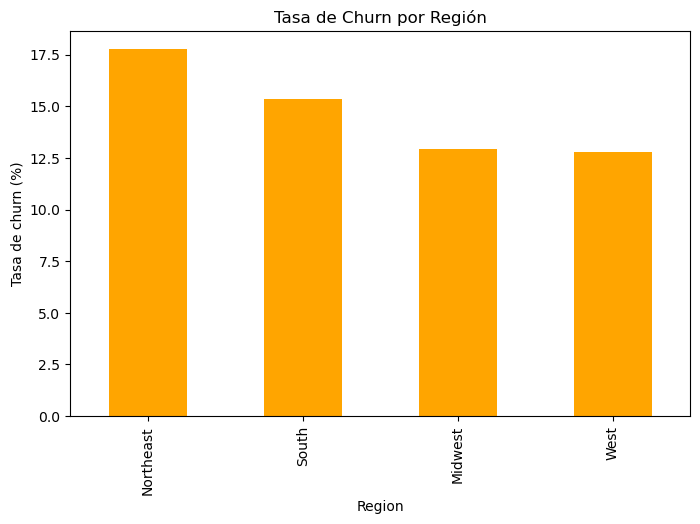

In [45]:
region_churn.plot(kind="bar", color="orange", figsize=(8,5), title="Tasa de Churn por Región")
plt.ylabel("Tasa de churn (%)")
plt.show()

## Análisis de la variable Estado y creación de Región

- La variable State tiene demasiadas categorías (51), lo que complica el modelado y puede generar ruido. Para simplificar y mantener la información geográfica, agrupamos los estados en 4 regiones principales de EE.UU.: Northeast, South, Midwest y West.

- Esta transformación reduce la complejidad del modelo, mejora su capacidad de generalización y facilita la interpretación. Además, al analizar las tasas de churn por región, encontramos diferencias claras: el Northeast tiene la mayor tasa de abandono (17.75%), mientras que Midwest y West tienen las menores (~13%).

- Incluir Region en lugar de State permite aprovechar patrones geográficos relevantes sin sobrecargar el modelo.

In [47]:
df.shape

(2666, 21)

In [338]:
categoricas = ["Area code", "International plan", "Voice mail plan", "Region"]

In [404]:
pvalue_results = {}

for v in categoricas:
    chi2, pvalue,dof, expected = chi2_contingency(pd.crosstab(df["Churn"], df[v]))
    pvalue_results[v] = pvalue
    print(f"{v}: Chi2 = {chi2:.2f} , Pvalue = {pvalue}\n")

pval_df = pd.DataFrame.from_dict(pvalue_results, orient = "index", columns=["Pvalue"])
pval_df = pval_df.sort_values(by="Pvalue", ascending = True)

Area code: Chi2 = 0.20 , Pvalue = 0.9056446754773072

International plan: Chi2 = 202.68 , Pvalue = 5.4269405491147075e-46

Voice mail plan: Chi2 = 25.66 , Pvalue = 4.079713016862758e-07

Region: Chi2 = 7.23 , Pvalue = 0.06500864168769073



In [390]:
pval_df

,Pvalue
International plan,5.426941e-46
Voice mail plan,4.079713e-07
Region,6.500864e-02
Area code,9.056447e-01


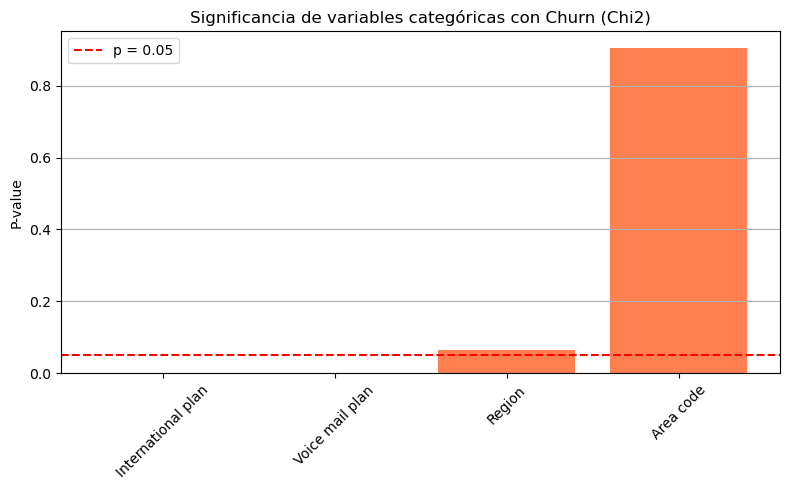

In [342]:
plt.figure(figsize=(8, 5))
plt.bar(pval_df.index, pval_df['Pvalue'], color='coral')
plt.ylabel("P-value")
plt.title("Significancia de variables categóricas con Churn (Chi2)")
plt.xticks(rotation=45)
plt.axhline(0.05, color='red', linestyle='--', label='p = 0.05')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


## Análisis de Chi-cuadrado entre variables categóricas y Churn

### ¿Qué hicimos?

Aplicamos el test de Chi-cuadrado de independencia (chi2_contingency) para cada una de las variables categóricas con respecto a la variable objetivo Churn. Esta prueba nos ayuda a detectar si existe una asociación estadística significativa entre ambas variables.

### ¿Por qué lo hicimos?

Queremos saber cuáles variables categóricas son relevantes para predecir la baja de clientes. Si una variable tiene un valor de p-value muy bajo, significa que no es independiente de Churn, o sea, puede aportar información útil al modelo.

### Resultados y conclusiones del test de Chi-cuadrado

| **Variable**           | **p-value**     | **Conclusión**                                                                 |
|------------------------|------------------|--------------------------------------------------------------------------------|
| `International plan`   | 5.42e-46         | ✅ Fuertemente relacionada con `Churn`. ¡Debe usarse en el modelo!             |
| `Voice mail plan`      | 4.07e-07         | ✅ Relación significativa. Útil para el modelo.                                |
| `Region`               | 0.0650           | ⚠️ Ligeramente por encima del umbral (0.05). Podría ser útil, pero con cautela.|
| `Area code`            | 0.9056           | ❌ No tiene relación significativa. Puede eliminarse sin perder valor.         |



### ¿Qué podemos sacar de esto?

- Las variables International plan y Voice mail plan son altamente informativas para predecir Churn y deben permanecer en el modelo.

- Region tiene un valor de p cercano al límite de 0.05. Puede mantenerse por ahora, especialmente si observamos que mejora el modelo.

- Area code no aporta valor predictivo. Puede ser eliminada para evitar ruido.

# 3.2 CHURN vs VARIABLES NUMERICAS

## Aqui faco os boxplot para ver q1, q2, q3 e outliers

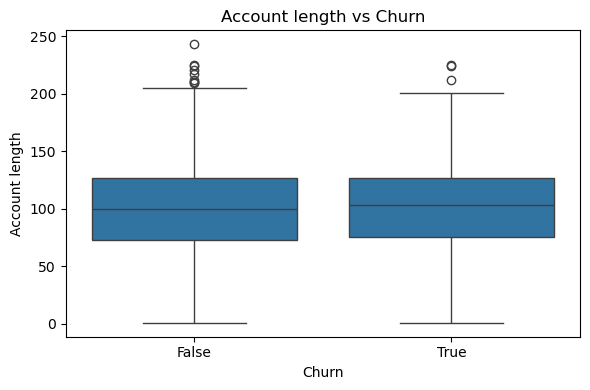

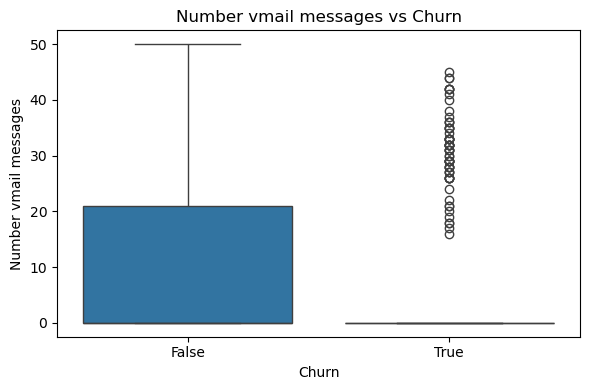

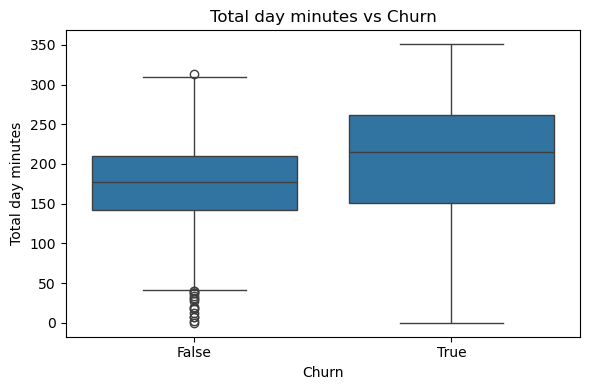

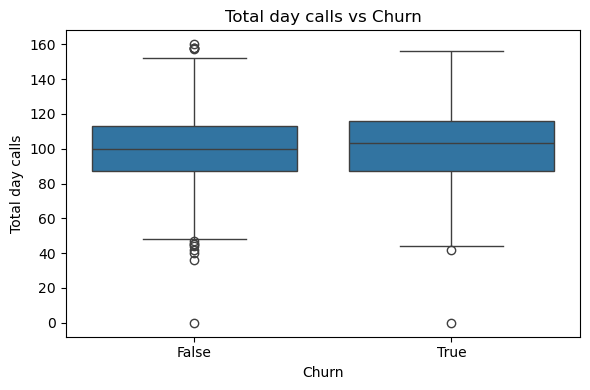

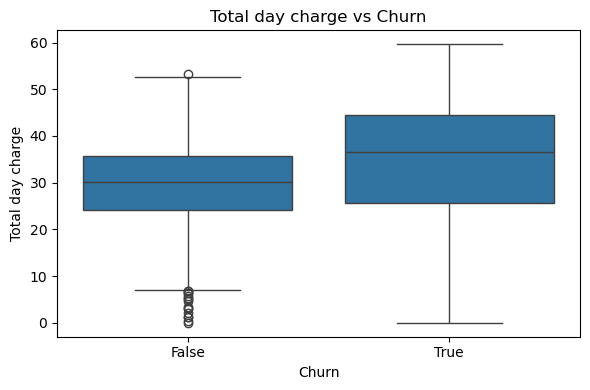

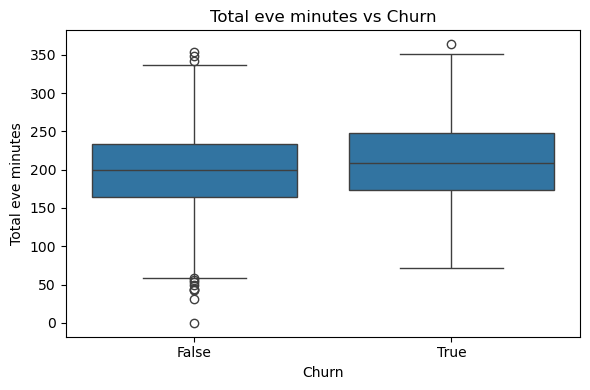

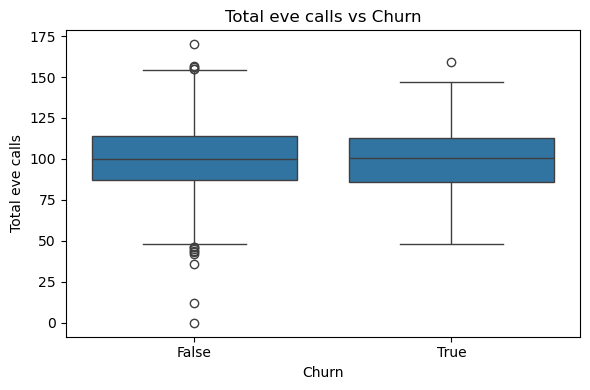

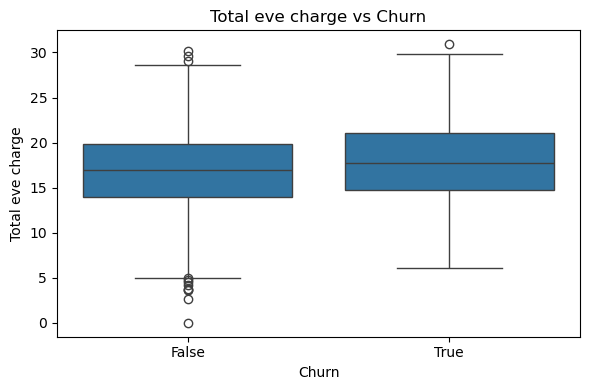

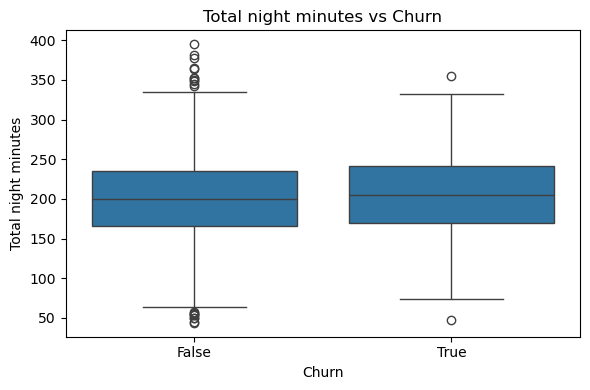

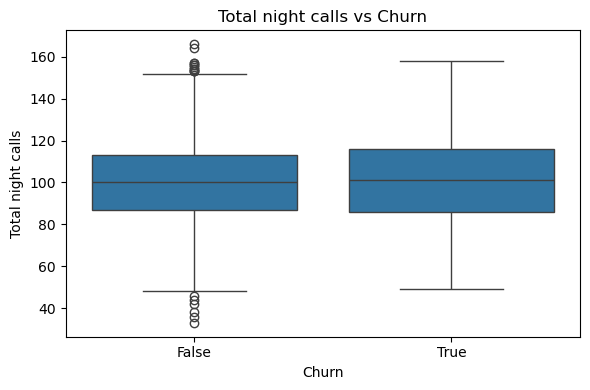

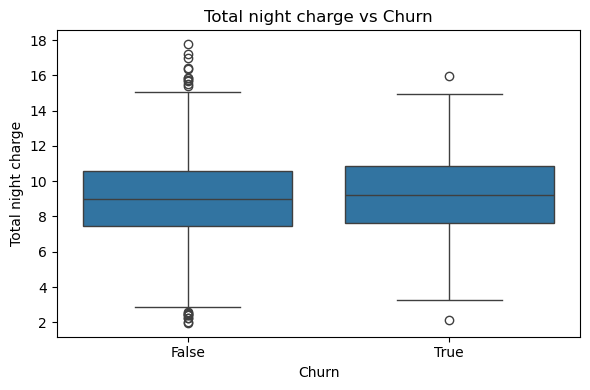

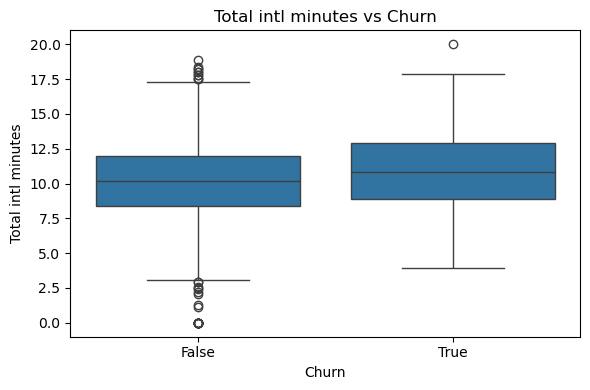

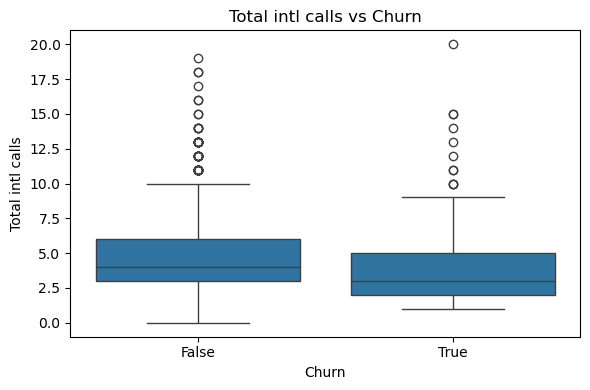

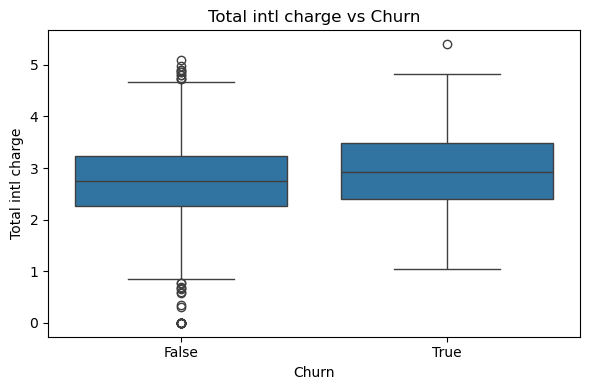

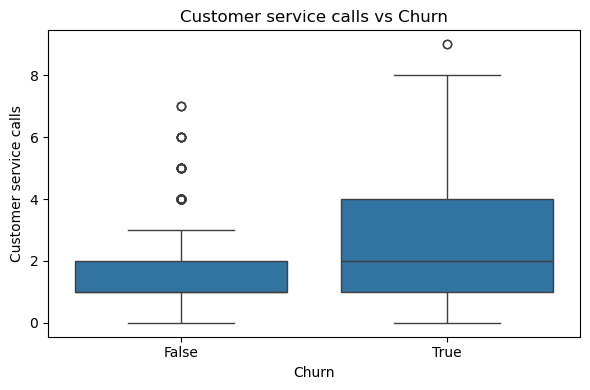

In [55]:
# Convertir churn a entero (True=1, False=0) para análisis numérico
df["Churn_int"] = df["Churn"].astype(int)

# 1. Boxplots para cada variable numérica vs churn
numeric_cols = [
    'Account length', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge',
    'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls',
    'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge',
    'Customer service calls'
]

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x="Churn", y=col)
    plt.title(f"{col} vs Churn")
    plt.tight_layout()
    plt.show()



## Agrupandp agora pelo churn e vendo a media de cada variavel para renovacion e Baja (True)

In [57]:
# 2. Promedios por grupo
means_by_churn = df.groupby("Churn")[numeric_cols].mean().T
print(means_by_churn)

Churn                        False       True 
Account length          100.330992  102.319588
Number vmail messages     8.507463    5.170103
Total day minutes       175.104346  205.181186
Total day calls         100.159350  101.195876
Total day charge         29.768266   34.881340
Total eve minutes       198.853380  209.385309
Total eve calls         100.036435   99.948454
Total eve charge         16.902809   17.797861
Total night minutes     200.464091  205.307216
Total night calls       100.007902  100.682990
Total night charge        9.020975    9.238892
Total intl minutes       10.137840   10.819330
Total intl calls          4.538191    4.051546
Total intl charge         2.737709    2.921727
Customer service calls    1.453029    2.206186


### ANalisando a correlacao entre as variables 

In [59]:
# Agregamos Churn_int
corr = df[numeric_cols + ['Churn_int']].corr()

# Ver sólo las correlaciones con Churn
corr_churn = corr['Churn_int'].sort_values(ascending=False)
print(corr_churn)


Churn_int                 1.000000
Customer service calls    0.202590
Total day charge          0.195689
Total day minutes         0.195688
Total intl charge         0.086216
Total intl minutes        0.086204
Total eve minutes         0.072906
Total eve charge          0.072893
Total night minutes       0.033639
Total night charge        0.033635
Total day calls           0.018290
Account length            0.017728
Total night calls         0.012262
Total eve calls          -0.001539
Total intl calls         -0.069882
Number vmail messages    -0.086474
Name: Churn_int, dtype: float64


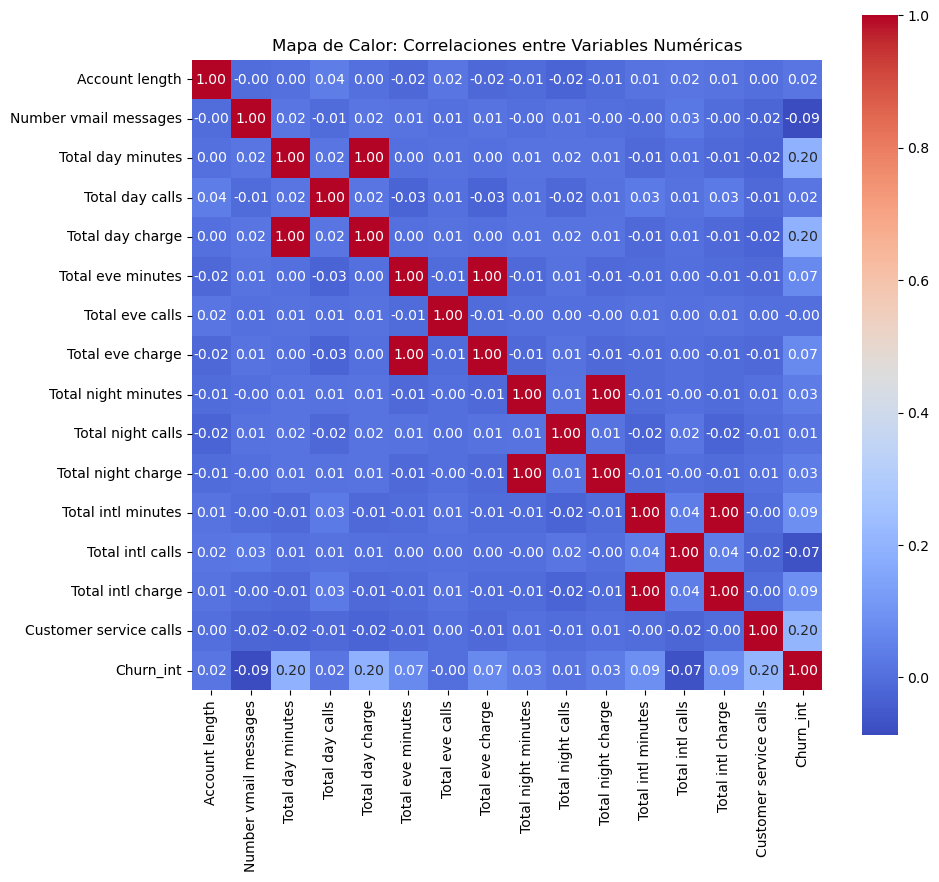

In [61]:
plt.figure(figsize=(10, 9))
sns.heatmap(corr,annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Mapa de Calor: Correlaciones entre Variables Numéricas")
plt.tight_layout()
plt.show()

# Ver la distribución de cada variable numérica

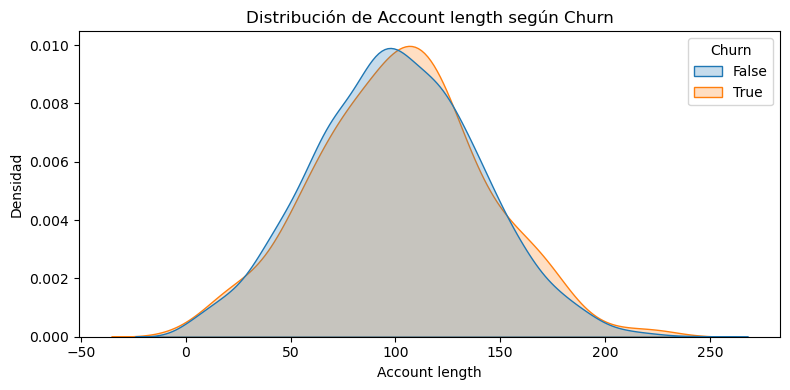

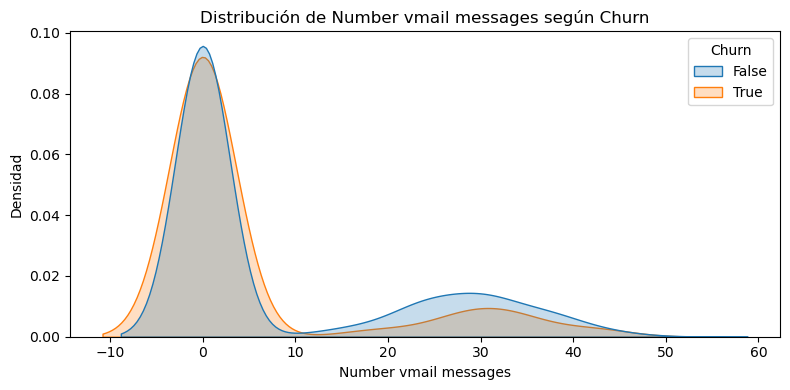

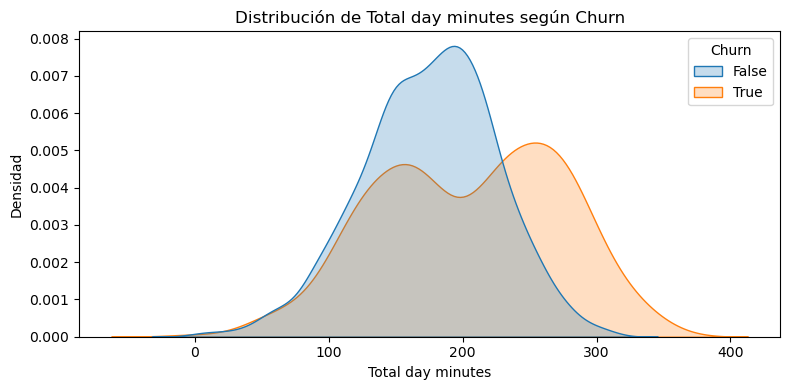

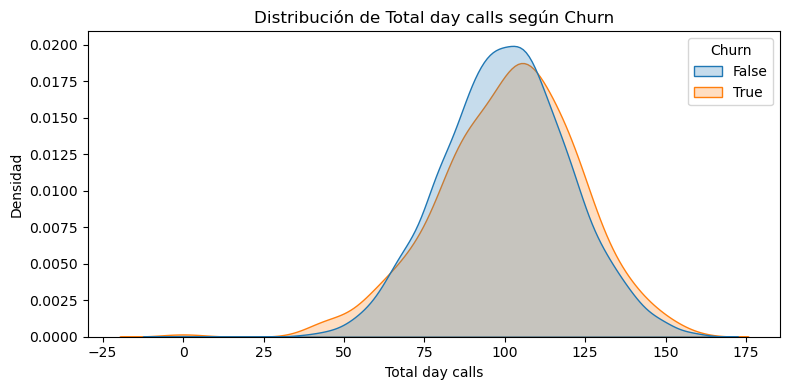

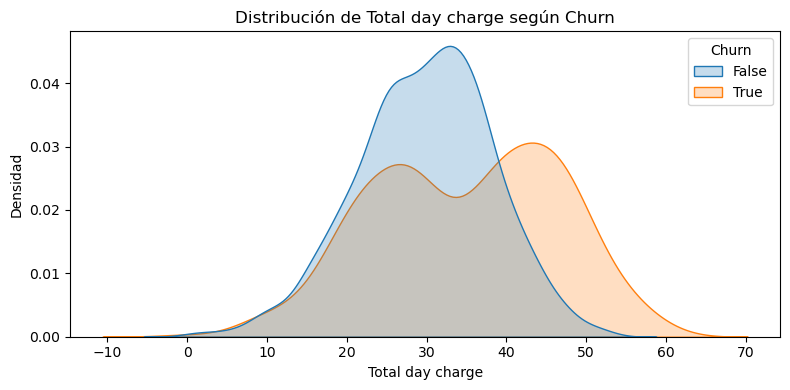

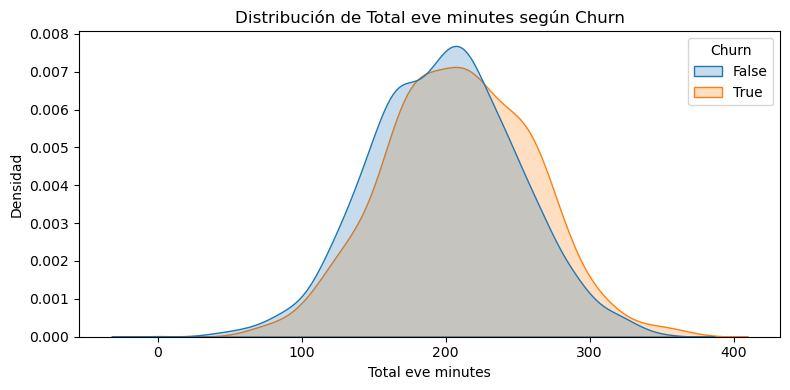

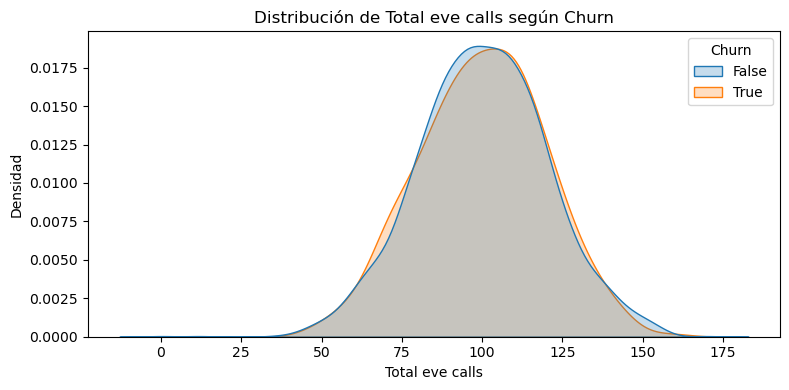

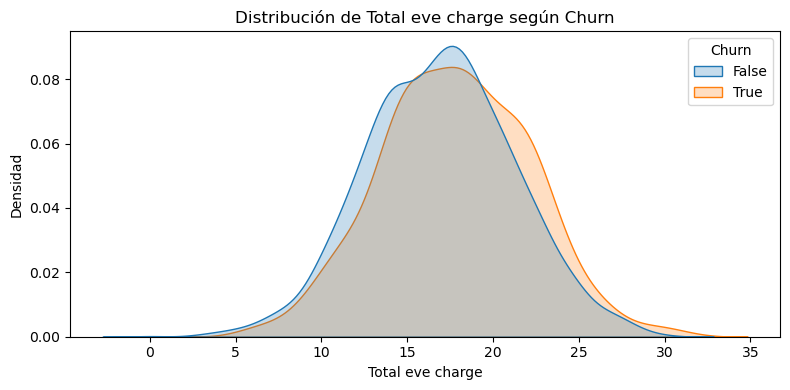

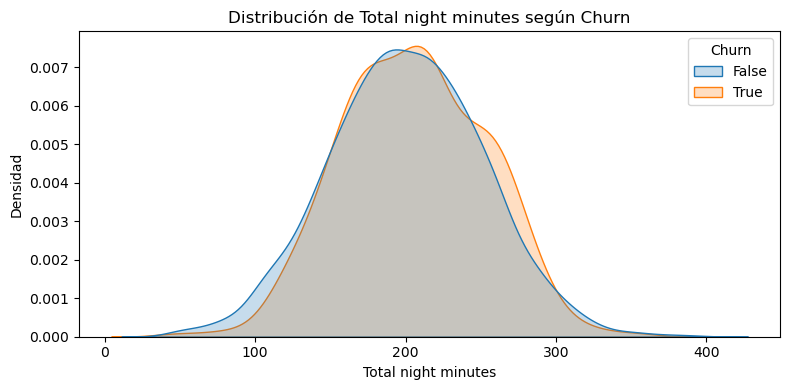

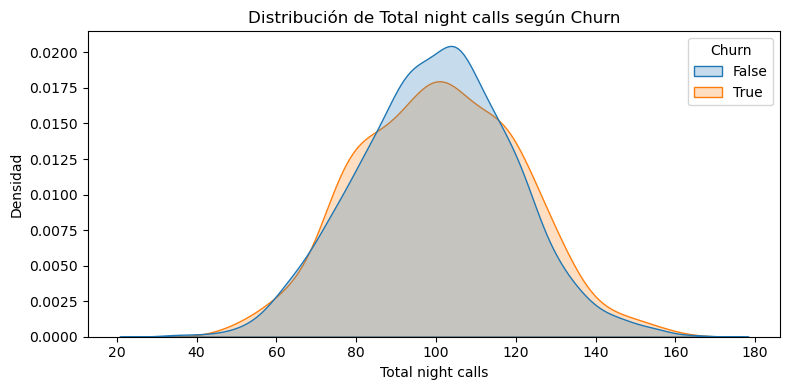

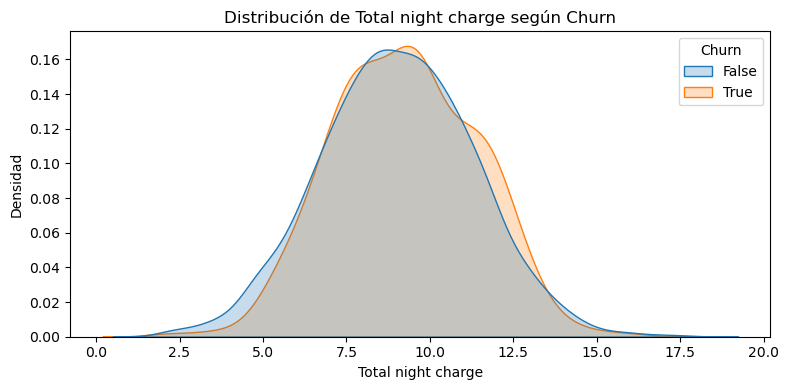

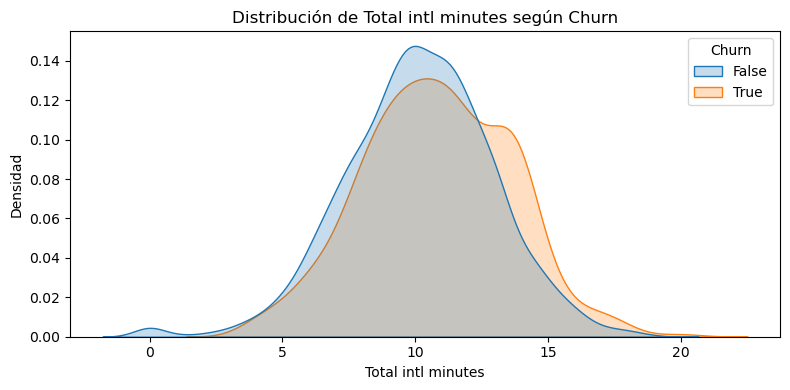

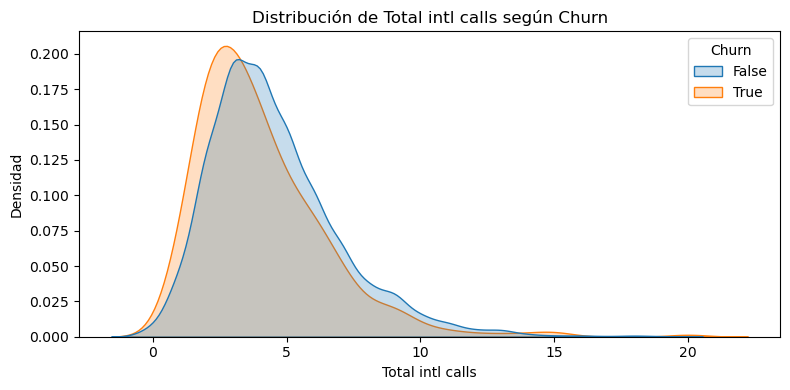

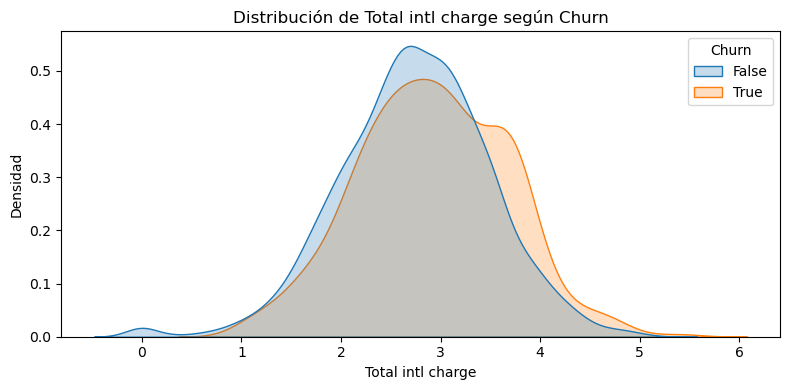

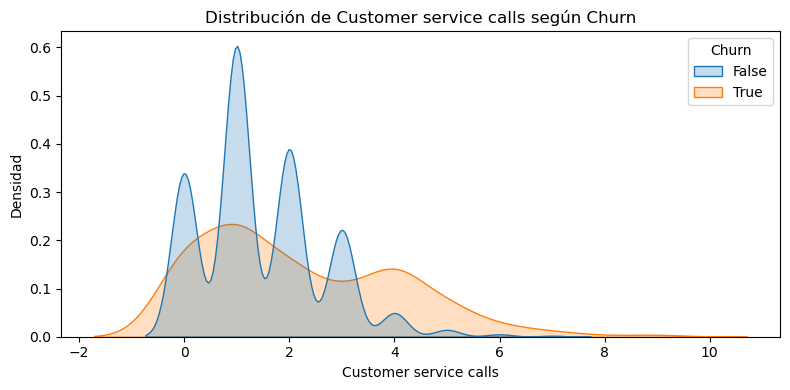

In [392]:
for n in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df, x=n, hue='Churn', common_norm=False, fill=True)
    plt.title(f'Distribución de {n} según Churn')
    plt.xlabel(n)
    plt.ylabel('Densidad')
    plt.tight_layout()
    plt.show()

In [63]:
# Verificar as hipotesis de churn e Numero de buzon de voz
df.groupby("Churn")["Number vmail messages"].count()

Churn
False    2278
True      388
Name: Number vmail messages, dtype: int64

## Conclusiones del Análisis de Promedios y Correlación

### 1. Promedios por grupo (means_by_churn)
Comparando clientes que no cancelaron (False) con los que sí cancelaron (True):

- Clientes que cancelan (Churn=True):

    - Usan más minutos y generan más cargos (especialmente en llamadas de día).

    - Llaman más al servicio al cliente (2.2 vs. 1.45).

    - Tienen menos mensajes de voz activados.

Esto sugiere que clientes que usan mucho el servicio o tienen más problemas (más llamadas al servicio) tienden a cancelar más.

### 2. Correlaciones con Churn_int
   
Las variables más correlacionadas positivamente con Churn son:

Variable	Correlación con Churn
Customer service calls	+0.20
Total day charge	+0.19
Total day minutes	+0.19
Total intl charge	+0.08
Total intl minutes	+0.08

# 4. Elegindo Variables Para el MODELO

In [286]:

variables_utiles = [
    'Account length', 'Number vmail messages',
    'Total day minutes', 'Total eve minutes', 'Total night minutes',
    'Total intl charge', 'Customer service calls',
    'International plan', 'Voice mail plan', 'Region','Churn_int'
]


9 variables eliminadas

eliminadas --> 1.State, 2.Area code , (3.Total day charge, 4.Total eve charge, 5.Total night charge), (6.Total day calls, 7.Total eve calls, 8.Total night calls y 9.Total intl calls).

## Variables Eliminadas:

    - State → reemplazado por Region.

    - Area code → no aporta información útil (identificador técnico), la media churn del area code son todos de ~14%

    - Total day charge, Total night charge, etc. → duplican info de minutos.

    - Total day calls, etc. → Eliminadas por baja correlación con el churn, mostran valores de correlacion cercanos a 0: Esto sugiere que el número de llamadas realizadas no influye significativamente en la decisión de cancelar el servicio. 
    
    - Redundancia con otras variables más informativas
    
Las llamadas suelen estar relacionadas con los minutos hablados, pero en este caso, los minutos totales (como Total day minutes) tienen una correlación mucho mayor con el churn:

👉 Esto indica que la duración de las llamadas importa más que la cantidad. 


# 5.0 Outliers and Missing

 - Hay muchos outliers en mis variables numericas, de esta manera, iré trabajar con modelos robustos a outliers, que no son sencibles a valores elevados (Random Forest, XGBoost, redes neurais), y solo tengo que preocuparme en escalonar y transformar variables categoricas.
   
 - No hay valores nulos en mi data frame, asi que no necesito sacar ningun valor missing


# 6.0 Machine Learning / Random Forest

### Porque iré usar Random Forest:

    - Robustez ante valores extremos (outliers) , No requiere escalado de variables numéricas, Tolera bien variables categóricas convertidas a booleanas, Permite interpretar la importancia de cada variable y Funciona muy bien en problemas de clasificación binaria, como en este caso: Churn (0 o 1)

In [288]:
# Data frame con las variables selecionadas

df_final= df[variables_utiles]

# Aqui podemo ver que todo via siguen como Object
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Account length          2666 non-null   int64  
 1   Number vmail messages   2666 non-null   int64  
 2   Total day minutes       2666 non-null   float64
 3   Total eve minutes       2666 non-null   float64
 4   Total night minutes     2666 non-null   float64
 5   Total intl charge       2666 non-null   float64
 6   Customer service calls  2666 non-null   int64  
 7   International plan      2666 non-null   object 
 8   Voice mail plan         2666 non-null   object 
 9   Region                  2666 non-null   object 
 10  Churn_int               2666 non-null   int32  
dtypes: float64(4), int32(1), int64(3), object(3)
memory usage: 218.8+ KB


## Paso 1: Indentificando y codificando variáveis categóricas
Necesitamos convertirlas en variables numéricas con get_dummies():

Porque las 3 variables que vamos modificar son  Categorica nominal (Sem ordem natural, One-Hot Enconding)

In [290]:
# El parámetro drop_first=True elimina una de las categorías de cada variable para evitar la multicolinealidad.

df_final = pd.get_dummies(df_final, columns=['International plan', 'Voice mail plan', 'Region'], drop_first=True)

In [292]:
# verificando variables booleanas
df_final.dtypes

Account length              int64
Number vmail messages       int64
Total day minutes         float64
Total eve minutes         float64
Total night minutes       float64
Total intl charge         float64
Customer service calls      int64
Churn_int                   int32
International plan_Yes       bool
Voice mail plan_Yes          bool
Region_Northeast             bool
Region_South                 bool
Region_West                  bool
dtype: object

## Paso 2: Separar las variables predictoras y definir alvo

In [294]:
# axis=1 remove la coluna , axis=0 removeria la linea
X = df_final.drop('Churn_int',axis=1)

# variable objetivo (ya convertida a numerica)
y = df_final['Churn_int']


## Paso 3: Separar en treino y teste con Stratify 

In [296]:
# stratify=y , sirve para mantener la proporcion del churn en test y treino
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=42, stratify=y)

### - Verificar balanceamento do stratify

In [298]:
print("Treino:")
print(y_train.value_counts(normalize=True).round(4) * 100)

print("Teste:")
print(y_test.value_counts(normalize=True).round(4) * 100)

Treino:
Churn_int
0    85.46
1    14.54
Name: proportion, dtype: float64
Teste:
Churn_int
0    85.39
1    14.61
Name: proportion, dtype: float64


# Paso 4: Entrenar el modelo

In [300]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(
    n_estimators = 100, # numero de arboles
    random_state = 42, # para reproducibilidad 
    n_jobs = -1        # usa todos los nucleos del procesador
)

# Entrenamos el modelo con los datos de entrenamiento
model_rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

# Paso 5: Hacer predicciones

In [302]:
y_pred = model_rf.predict(X_test)

# Paso 6: Evaluar el modelo

In [304]:
from sklearn.metrics import classification_report, confusion_matrix

print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4))

Matriz de confusión:
[[451   5]
 [ 29  49]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9396    0.9890    0.9637       456
           1     0.9074    0.6282    0.7424        78

    accuracy                         0.9363       534
   macro avg     0.9235    0.8086    0.8530       534
weighted avg     0.9349    0.9363    0.9314       534



- Accuracy (precisión general)

- Precision (exactitud de los positivos predichos)

- Recall (capacidad de detectar churners reales)

- F1-score (balance entre precision y recall)

- Matriz de confusión

# 📌 Conclusión del primer modelo (Random Forest)

Entrenamos un modelo de Random Forest para predecir la deserción de clientes (churn) en una empresa de telecomunicaciones. Este modelo logró una exactitud del 93,6%, lo que indica un excelente rendimiento general.

Sin embargo, al analizar más a fondo:

    - El modelo identificó muy bien a los clientes que no cancelan (precisión de 93,9% y recall de 98,9%).

    - Pero tuvo dificultad para detectar a los que sí cancelan: el recall fue solo del 62,8%, lo que significa que muchos clientes que se dieron de baja no fueron correctamente detectados.

    - Esto es importante porque, aunque el modelo es muy bueno en general, no es suficientemente sensible a los casos de churn, que son justamente los más valiosos para el negocio.

- Próximos pasos
    
Ajustar los hiperparámetros del modelo para mejorar el recall de los clientes que cancelan.

Probar otros modelos (como XGBoost o redes neuronales).

Usar técnicas de balanceo (como SMOTE o submuestreo) para mejorar la detección de la clase minoritaria.

Evaluar el modelo con el conjunto de prueba final (churn-bigml-20.csv) para validar su desempeño real.

# Analisar la importancia de cada variable en el modelo

- Con este analise, puedo considerar retinar las variables que no son tan importantes para definir el churn, con eso puedo diminuir el ruido y mejorar la predicion

In [310]:
# Extraindo a importância das features
importances = model_rf.feature_importances_ 

# Nome das colunas usadas no modelo
colunas_name = X_train.columns

# Criando un dataFrame ordenando por importancia
df_importancia = pd.DataFrame({
    "Nome Colunas": colunas_name,
    "Importancia": importances
}).sort_values(by="Importancia", ascending=False)

print(df_importancia)

              Nome Colunas  Importancia
2        Total day minutes     0.283513
6   Customer service calls     0.140474
3        Total eve minutes     0.134836
5        Total intl charge     0.101449
4      Total night minutes     0.094796
7   International plan_Yes     0.093791
0           Account length     0.077846
1    Number vmail messages     0.028706
8      Voice mail plan_Yes     0.015389
10            Region_South     0.010626
9         Region_Northeast     0.009636
11             Region_West     0.008937


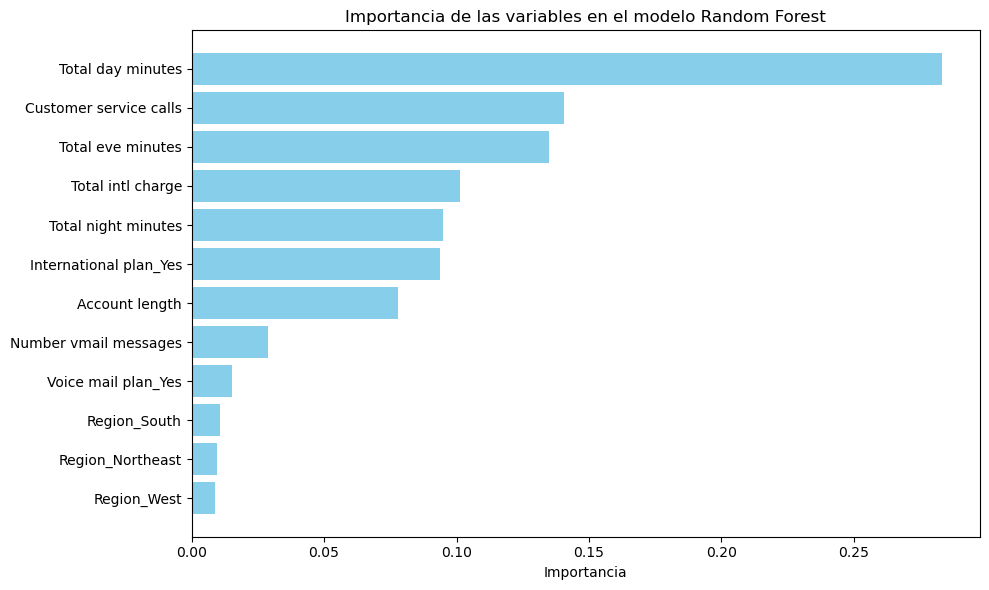

In [314]:
# Plotando gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(df_importancia["Nome Colunas"], df_importancia["Importancia"], color='skyblue')
plt.gca().invert_yaxis()  # Inverte o eixo para mostrar a mais importante no topo
plt.title('Importancia de las variables en el modelo Random Forest')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()